# Case 3. Medical Text Categorization

Saana Vallius

Last updated: 11.3.2018

### 1. Objectives

The objective for this assignment is to build a neural network for classifying a database of medical texts. Additionally, the goal is to learn about natural language processing and the use of 1D-convolutional recurrent neural networks.

### 2. Data description

The Ohsumed dataset used in this assignment consists of 20,000 medical paper abstracts. The abstracts have been prelabeled into a total of 23 categories of cardiovascular diseases based on those abstracts. The provider of the dataset has divided the data 50/50 into training and testing sets in separate directories.

|Categories of the dataset                                    |
|:-------|:---------------------------------------------------|
|   C01  | Bacterial Infections and Mycoses                   |
|   C02  | Virus Diseases                                     |
|   C03  | Parasitic Diseases                                 |
|   C04  | Neoplasms                                          |
|   C05  | Musculoskeletal Diseases                           |
|   C06  | Digestive System Diseases                          |
|   C07  | Stomatognathic Diseases                            |
|   C08  | Respiratory Tract Diseases                         |
|   C09  | Otorhinolaryngologic Diseases                      |
|   C10  | Nervous System Diseases                            |
|   C11  | Eye Diseases                                       |
|   C12  | Urologic and Male Genital Diseases                 |
|   C13  | Female Genital Diseases and Pregnancy Complications|
|   C14  | Cardiovascular Diseases                            |
|   C15  | Hemic and Lymphatic Diseases                       |
|   C16  | Neonatal Diseases and Abnormalities                |
|   C17  | Skin and Connective Tissue Diseases                |
|   C18  | Nutritional and Metabolic Diseases                 |
|   C19  | Endocrine Diseases                                 |
|   C20  | Immunologic Diseases                               |
|   C21  | Disorders of Environmental Origin                  |
|   C22  | Animal Diseases                                    |
|   C23  | Pathological Conditions, Signs and Symptoms        |

The dataset can be downloaded from here: http://disi.unitn.it/moschitti/corpora/ohsumed-first-20000-docs.tar.gz.

#### Required imports

In [74]:
from keras.layers import Flatten, Dense, Embedding, LSTM, Conv1D, MaxPooling1D, GlobalMaxPooling1D
import numpy as np
import matplotlib.pyplot as plt
from keras import preprocessing
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
import os
import timeit

### 3. Preprocessing

* Define the key values for the word embedding
* Load the data
* Save the labels and texts of the abstracts into variable
* Shuffle the data
* Check the length of the train and test data

#### Define embedding values

In [75]:
# Maximum number of words
max_words = 10000
# Use the 50 first words only
maxlen = 500

#### Train data

In [76]:
ohsumed_dir = 'ohsumed-first-20000-docs/'
train_dir = os.path.join(ohsumed_dir, 'training')

#First create empty lists
labels = []
texts = []

# Generate a list L = ['C01', 'C02, ..., 'C023'] for the categories
L = ['C{:02}'.format(n) for n in range(1, 23 + 1)]
for label_type in L:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        f = open(os.path.join(dir_name, fname))
        texts.append(f.read())
        f.close()
        i = L.index(label_type)
        labels.append(i)

In [77]:
#Tokenize the data
tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [78]:
#Pad the sequences so that all samples are at least >maxlen< in lenght
train_data = pad_sequences(sequences, maxlen=maxlen)
train_labels = to_categorical(labels)

In [79]:
#Shuffle the data
indices = np.arange(train_data.shape[0])
np.random.shuffle(indices)
train_data = train_data[indices]
train_labels = train_labels[indices]

#### Test data

In [80]:
test_dir = os.path.join(ohsumed_dir, 'test')

test_labels = []
test_texts = []

for label_type in L:
    dir_name = os.path.join(test_dir, label_type)
    for fname in os.listdir(dir_name):
        f = open(os.path.join(dir_name, fname))
        test_texts.append(f.read())
        f.close()
        i = L.index(label_type)
        test_labels.append(i)

In [81]:
#Tokenize the data
tokenizer.fit_on_texts(test_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

In [82]:
#Pad the sequences so that all samples are at least >maxlen< in lenght
test_data = pad_sequences(test_sequences, maxlen=maxlen)
test_labels = to_categorical(test_labels)

In [83]:
#Shuffle the data
indices = np.arange(test_data.shape[0])
np.random.shuffle(indices)
test_data = test_data[indices]
test_labels = test_labels[indices]

Now the data has been loaded, tokenized, padded and separated to two sets:
* train_data, train_labels for training
* test_data, test_labels for testing

In [84]:
# Check that there are indeed 10,000 training and 10,000 test samples
print("Train samples:", (len(train_data)), "\nTest samples:", len(test_data))

Train samples: 10433 
Test samples: 12733


The amounts of train and test samples suggest that the information given by the provider of the dataset having 20,000 samples in total is incorrect. In fact 10,433 training samples and 12,733 test samples reside in the original directories adding up to 23,166 samples altogether.

### 4. Modelling

We'll make two models - a recurrent neural network and another with 1D convolution.

#### RNN

In [85]:
#The base of the model using an embedding layer with an LSTM layer on top
RNN_model = Sequential()
RNN_model.add(Embedding(max_words, 16, input_length=maxlen))
RNN_model.add(LSTM(16,dropout=0.2, recurrent_dropout=0.2))

#Classifier
RNN_model.add(Dense(23, activation='softmax'))
RNN_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
RNN_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 500, 16)           160000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dense_4 (Dense)              (None, 23)                391       
Total params: 162,503
Trainable params: 162,503
Non-trainable params: 0
_________________________________________________________________


In [86]:
#Train the model and time the training
start_time = timeit.default_timer()
RNN_history = RNN_model.fit(train_data, train_labels,
                    epochs=7,
                    batch_size=32,
                    validation_split=0.2)
ex_time = timeit.default_timer() - start_time;
print('Execution time:',ex_time,'seconds')

Train on 8346 samples, validate on 2087 samples
Epoch 1/7
8346/8346 [==============================] - 279s 33ms/step - loss: 2.8687 - acc: 0.1679 - val_loss: 2.7973 - val_acc: 0.1802
Epoch 2/7
8346/8346 [==============================] - 304s 36ms/step - loss: 2.7966 - acc: 0.1701 - val_loss: 2.7889 - val_acc: 0.1802
Epoch 3/7
8346/8346 [==============================] - 285s 34ms/step - loss: 2.7718 - acc: 0.1705 - val_loss: 2.7576 - val_acc: 0.1802
Epoch 4/7
8346/8346 [==============================] - 282s 34ms/step - loss: 2.6958 - acc: 0.1747 - val_loss: 2.7378 - val_acc: 0.1850
Epoch 5/7
8346/8346 [==============================] - 267s 32ms/step - loss: 2.6350 - acc: 0.1966 - val_loss: 2.7105 - val_acc: 0.2271
Epoch 6/7
8346/8346 [==============================] - 281s 34ms/step - loss: 2.5567 - acc: 0.2291 - val_loss: 2.6763 - val_acc: 0.2310
Epoch 7/7
8346/8346 [==============================] - 275s 33ms/step - loss: 2.4919 - acc: 0.2551 - val_loss: 2.6445 - val_acc: 0.2415


#### 1D convolution

In [96]:
#The base of the model using 1D convolution and max pooling layers
conv_model = Sequential()
conv_model.add(Embedding(max_words, 32, input_length=maxlen))
conv_model.add(layers.Conv1D(32, 7, activation='relu'))
conv_model.add(layers.MaxPooling1D(5))
conv_model.add(layers.Conv1D(32, 7, activation='relu'))
conv_model.add(layers.GlobalMaxPooling1D())

#Classifier
conv_model.add(Dense(23, activation='softmax'))
conv_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
conv_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 500, 32)           320000    
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 494, 32)           7200      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 23)                759       
Total params: 335,159
Trainable params: 335,159
Non-trainable params: 0
_________________________________________________________________


In [97]:
#Train the model and time the training
start_time = timeit.default_timer()
conv_history = conv_model.fit(train_data, train_labels,
                    epochs=7,
                    batch_size=32,
                    validation_split=0.2)
ex_time = timeit.default_timer() - start_time;
print('Execution time:',ex_time,'seconds')

Train on 8346 samples, validate on 2087 samples
Epoch 1/7
8346/8346 [==============================] - 48s 6ms/step - loss: 2.8384 - acc: 0.1688 - val_loss: 2.7743 - val_acc: 0.1802
Epoch 2/7
8346/8346 [==============================] - 47s 6ms/step - loss: 2.6625 - acc: 0.2148 - val_loss: 2.5931 - val_acc: 0.2549
Epoch 3/7
8346/8346 [==============================] - 49s 6ms/step - loss: 2.4806 - acc: 0.2783 - val_loss: 2.4927 - val_acc: 0.2952
Epoch 4/7
8346/8346 [==============================] - 51s 6ms/step - loss: 2.3287 - acc: 0.3202 - val_loss: 2.4433 - val_acc: 0.2861
Epoch 5/7
8346/8346 [==============================] - 51s 6ms/step - loss: 2.2149 - acc: 0.3323 - val_loss: 2.4505 - val_acc: 0.2885
Epoch 6/7
8346/8346 [==============================] - 48s 6ms/step - loss: 2.1251 - acc: 0.3527 - val_loss: 2.4518 - val_acc: 0.2832
Epoch 7/7
8346/8346 [==============================] - 50s 6ms/step - loss: 2.0438 - acc: 0.3778 - val_loss: 2.4720 - val_acc: 0.2722
Execution time

### 5. Evaluating

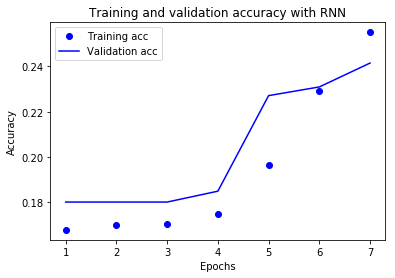

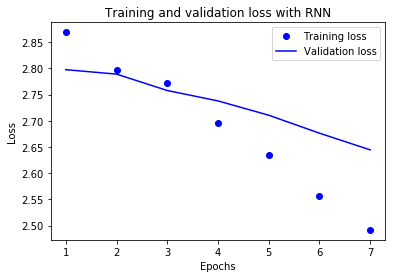

In [98]:
#Plot the accuracies
RNN_acc = RNN_history.history['acc']
epochs = range(1, len(RNN_acc) + 1)
RNN_val_acc = RNN_history.history['val_acc']
plt.plot(epochs, RNN_acc, 'bo', label='Training acc')
plt.plot(epochs, RNN_val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy with RNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Plot the losses
RNN_loss = RNN_history.history['loss']
RNN_val_loss = RNN_history.history['val_loss']
plt.plot(epochs, RNN_loss, 'bo', label='Training loss')
plt.plot(epochs, RNN_val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss with RNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [99]:
RNN_res = RNN_model.evaluate(test_data, test_labels)
print(RNN_res)

12733/12733 [==============================] - 56s 4ms/step
[2.842810397528988, 0.16775308255664143]


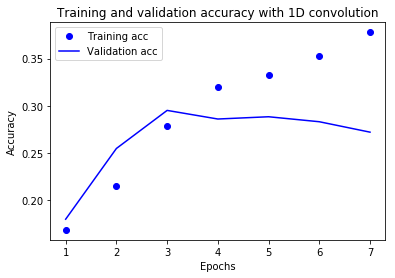

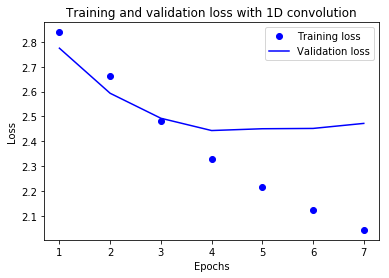

In [100]:
#Plot the accuracies
conv_acc = conv_history.history['acc']
epochs = range(1, len(conv_acc) + 1)
conv_val_acc = conv_history.history['val_acc']
plt.plot(epochs, conv_acc, 'bo', label='Training acc')
plt.plot(epochs, conv_val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy with 1D convolution')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Plot the losses
conv_loss = conv_history.history['loss']
conv_val_loss = conv_history.history['val_loss']
plt.plot(epochs, conv_loss, 'bo', label='Training loss')
plt.plot(epochs, conv_val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss with 1D convolution')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [101]:
conv_res = conv_model.evaluate(test_data, test_labels)
print(conv_res)

12733/12733 [==============================] - 23s 2ms/step
[3.191106215094786, 0.14615565852392201]


It seems that the results aren't very good with the training set. The portion of the dataset providers predivided testing set takes over 50% of the whole dataset. It might be a good idea to transfer some of the samples in the testing set to the training material. Let's do the transfer this way:

|      |  original  | new   |
|------|------------|-------|
|train |  10433     | 20000 |
|test  |  12733     | 3166  |

### 6. Rearrange the data

In [102]:
#Pick indeces 1 to 9567 of test data to be transfered to train data
transfer = test_data[:9567,:]
transfer_labels = test_labels[:9567,]
#Save the remaining indeces to be the new test data partition
new_test_data = test_data[9567:,:]
new_test_labels = test_labels[9567:,]

#Concatenate the train arrays with the transfer values
new_train_data = np.concatenate((train_data, transfer), axis=0)
new_train_labels = np.concatenate((train_labels, transfer_labels), axis=0)

In [103]:
#Verify the changes
print(new_train_data.shape)
print(new_train_labels.shape)
print(new_test_data.shape)
print(new_test_labels.shape)

(20000, 500)
(20000, 23)
(3166, 500)
(3166, 23)


### 7. Train the models again

In [104]:
#Train the RNN model and time the training
start_time = timeit.default_timer()
RNN_history = RNN_model.fit(new_train_data, new_train_labels,
                    epochs=7,
                    batch_size=32,
                    validation_split=0.2)
ex_time = timeit.default_timer() - start_time;
print('Execution time:',ex_time,'seconds')

Train on 16000 samples, validate on 4000 samples
Epoch 1/7
16000/16000 [==============================] - 528s 33ms/step - loss: 2.5862 - acc: 0.2331 - val_loss: 2.7558 - val_acc: 0.1923
Epoch 2/7
16000/16000 [==============================] - 526s 33ms/step - loss: 2.5240 - acc: 0.2509 - val_loss: 2.7187 - val_acc: 0.2087
Epoch 3/7
16000/16000 [==============================] - 582s 36ms/step - loss: 2.4661 - acc: 0.2603 - val_loss: 2.7005 - val_acc: 0.2150
Epoch 4/7
16000/16000 [==============================] - 535s 33ms/step - loss: 2.4228 - acc: 0.2699 - val_loss: 2.7097 - val_acc: 0.2230
Epoch 5/7
16000/16000 [==============================] - 529s 33ms/step - loss: 2.3780 - acc: 0.2840 - val_loss: 2.6965 - val_acc: 0.2170
Epoch 6/7
16000/16000 [==============================] - 543s 34ms/step - loss: 2.3358 - acc: 0.2961 - val_loss: 2.7017 - val_acc: 0.2248
Epoch 7/7
16000/16000 [==============================] - 595s 37ms/step - loss: 2.2966 - acc: 0.3060 - val_loss: 2.7084 - v

In [105]:
#Train the 1D convolution model and time the training
start_time = timeit.default_timer()
conv_history = conv_model.fit(new_train_data, new_train_labels,
                    epochs=7,
                    batch_size=32,
                    validation_split=0.2)
ex_time = timeit.default_timer() - start_time;
print('Execution time:',ex_time,'seconds')

Train on 16000 samples, validate on 4000 samples
Epoch 1/7
16000/16000 [==============================] - 116s 7ms/step - loss: 2.3445 - acc: 0.3047 - val_loss: 2.6791 - val_acc: 0.2228
Epoch 2/7
16000/16000 [==============================] - 129s 8ms/step - loss: 2.1678 - acc: 0.3475 - val_loss: 2.6083 - val_acc: 0.2328
Epoch 3/7
16000/16000 [==============================] - 138s 9ms/step - loss: 2.0344 - acc: 0.3781 - val_loss: 2.6198 - val_acc: 0.2352
Epoch 4/7
16000/16000 [==============================] - 124s 8ms/step - loss: 1.9148 - acc: 0.4096 - val_loss: 2.6162 - val_acc: 0.2345
Epoch 5/7
16000/16000 [==============================] - 113s 7ms/step - loss: 1.8057 - acc: 0.4377 - val_loss: 2.6438 - val_acc: 0.2235
Epoch 6/7
16000/16000 [==============================] - 104s 7ms/step - loss: 1.7027 - acc: 0.4610 - val_loss: 2.6960 - val_acc: 0.2255
Epoch 7/7
16000/16000 [==============================] - 103s 6ms/step - loss: 1.6114 - acc: 0.4856 - val_loss: 2.7750 - val_acc:

### 8. Evaluate once more

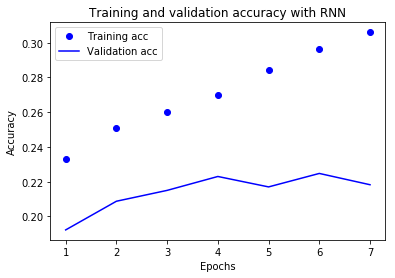

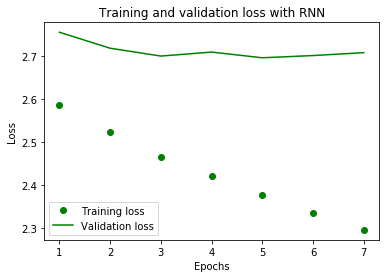

In [106]:
#Plot the accuracies
RNN_acc = RNN_history.history['acc']
epochs = range(1, len(RNN_acc) + 1)
RNN_val_acc = RNN_history.history['val_acc']
plt.plot(epochs, RNN_acc, 'bo', label='Training acc')
plt.plot(epochs, RNN_val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy with RNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Plot the losses
RNN_loss = RNN_history.history['loss']
RNN_val_loss = RNN_history.history['val_loss']
plt.plot(epochs, RNN_loss, 'go', label='Training loss')
plt.plot(epochs, RNN_val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss with RNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [110]:
RNN_res = RNN_model.evaluate(new_test_data, new_test_labels)
print(RNN_res)

3166/3166 [==============================] - 16s 5ms/step
[2.7130101272296243, 0.21320277959842585]


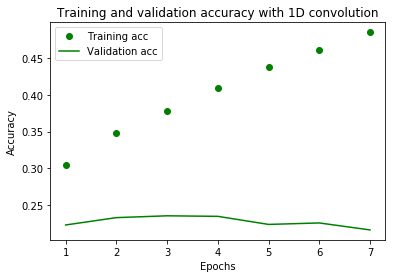

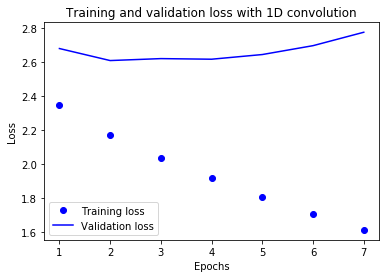

In [108]:
#Plot the accuracies
conv_acc = conv_history.history['acc']
epochs = range(1, len(conv_acc) + 1)
conv_val_acc = conv_history.history['val_acc']
plt.plot(epochs, conv_acc, 'go', label='Training acc')
plt.plot(epochs, conv_val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy with 1D convolution')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Plot the losses
conv_loss = conv_history.history['loss']
conv_val_loss = conv_history.history['val_loss']
plt.plot(epochs, conv_loss, 'bo', label='Training loss')
plt.plot(epochs, conv_val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss with 1D convolution')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [111]:
conv_res = conv_model.evaluate(new_test_data, new_test_labels)
print(conv_res)

3166/3166 [==============================] - 7s 2ms/step
[2.7396850251579163, 0.21699305123455978]


### 9. Results


|         |  Execution times (min)    |            |
|---------|---------------------------|------------|
|         |  Original divide          | New divide | 
|  RNN    |            33             |     64     |
|1D Conv  |            6              |     14     |

As seen in the table, the execution times for training 1D convolutional network are much lower than those of the RNNs. The new division of the train and test data seemed to almost double the execution time for both network types.



|              | Best val. acc / round                       |  Best loss / round          | Test Accuracy | Test Loss |
|:-------------|:--------------------------------------------|:----------------------------|:--------------|:----------|
|  RNN  orig.  |         24.2% / 7                           |          2.64               |  16.8%        |  2.84     |
|1D Conv orig. |         29.5% / 3                           |          2.44               |  14.6%        |  3.19     |
|  RNN   new   |         22.5% / 6                           |          2.70               |  21.3%        |  2.71     |
|1D Conv new   |         23.5% / 3                           |          2.61               |  21.7%        |  2.73     |

As the result table shows, it seems that 1D convolutional networks seem to perform on most occasions better on this particular problem than the recurrent neural network. Of course, the hyperparameters of the network may also have an effect. Anyhow, it looks like the best way to go is with a 1D convolutional network. 

After the transfer of some of the test data to the training data, the networks began to overfit quite severely. A more complex model might reduce the overfitting.

Let's build one last model based on these findings to try and reach an even better result.

### 10. Final model

In [121]:
#The base of the model using 1D convolution and max pooling layers
conv_model = Sequential()
conv_model.add(Embedding(max_words, 64, input_length=maxlen))
conv_model.add(layers.Conv1D(32, 7, activation='relu'))
conv_model.add(layers.MaxPooling1D(5))
conv_model.add(layers.Conv1D(32, 7, activation='relu'))
conv_model.add(layers.GlobalMaxPooling1D())

#Classifier
conv_model.add(Dense(23, activation='softmax'))
conv_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
conv_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 500, 64)           640000    
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 494, 32)           14368     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 32)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 23)                759       
Total params: 662,327
Trainable params: 662,327
Non-trainable params: 0
_________________________________________________________________


In [122]:
#Train the 1D convolution model and time the training
start_time = timeit.default_timer()
conv_history = conv_model.fit(new_train_data, new_train_labels,
                    epochs=7,
                    batch_size=32,
                    validation_split=0.2)
ex_time = timeit.default_timer() - start_time;
print('Execution time:',ex_time,'seconds')

Train on 16000 samples, validate on 4000 samples
Epoch 1/7
16000/16000 [==============================] - 221s 14ms/step - loss: 2.7932 - acc: 0.1872 - val_loss: 2.7468 - val_acc: 0.2110
Epoch 2/7
16000/16000 [==============================] - 185s 12ms/step - loss: 2.5899 - acc: 0.2521 - val_loss: 2.6089 - val_acc: 0.2417
Epoch 3/7
16000/16000 [==============================] - 169s 11ms/step - loss: 2.3997 - acc: 0.2914 - val_loss: 2.5272 - val_acc: 0.2472
Epoch 4/7
16000/16000 [==============================] - 168s 10ms/step - loss: 2.2247 - acc: 0.3287 - val_loss: 2.4881 - val_acc: 0.2530
Epoch 5/7
16000/16000 [==============================] - 169s 11ms/step - loss: 2.0571 - acc: 0.3727 - val_loss: 2.4987 - val_acc: 0.2615
Epoch 6/7
16000/16000 [==============================] - 169s 11ms/step - loss: 1.9052 - acc: 0.4147 - val_loss: 2.5840 - val_acc: 0.2472
Epoch 7/7
16000/16000 [==============================] - 173s 11ms/step - loss: 1.7642 - acc: 0.4497 - val_loss: 2.5812 - v

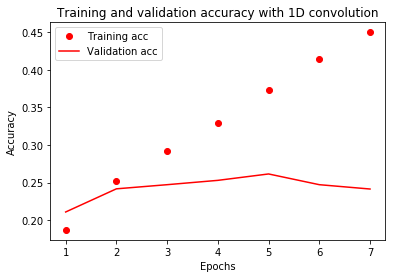

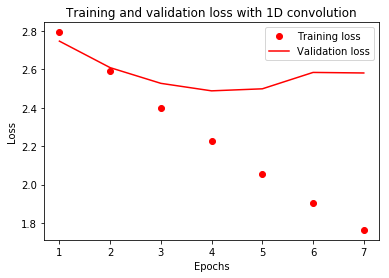

In [123]:
#Plot the accuracies
conv_acc = conv_history.history['acc']
epochs = range(1, len(conv_acc) + 1)
conv_val_acc = conv_history.history['val_acc']
plt.plot(epochs, conv_acc, 'ro', label='Training acc')
plt.plot(epochs, conv_val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy with 1D convolution')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Plot the losses
conv_loss = conv_history.history['loss']
conv_val_loss = conv_history.history['val_loss']
plt.plot(epochs, conv_loss, 'ro', label='Training loss')
plt.plot(epochs, conv_val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss with 1D convolution')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [124]:
conv_res = conv_model.evaluate(new_test_data, new_test_labels)
print(conv_res)

3166/3166 [==============================] - 11s 3ms/step
[2.5722431763018223, 0.24889450415319381]


### 11 Conclusions

The results for this categorization task can seems quite dissappointing. Nevertheless, comparing to making pure guesses in classifying the texts into 23 separate categories, the sample count in the categories ranging from 65 to 1,799 (Juha Kopu, 9.3.2018), the result is acceptable. As always, the biggest problem is not having enough data to train the network on. A portion of this problem was beaten by rearranging the dataset more meaningfully into training and testing sets of sensible sizes with quite a simple trick. All in all, with this particular problem, !D seemed to win the competition for performance.

| Statistics of the final model   |
|---------------------------------|
| Execution time           21 min |
| Best validation accuracy  26.2% |
| Best loss                 2.49  |
| Test accuracy             24.9% | 
| Test loss                 2.57  |

Even the most accurate model here would probably not be good enough for any practical use in classifying medical papers, but with a larger, more evenly distributed, adequately preprocesesed database, a problem of such would be manageable.